In [1]:
import warnings
warnings.filterwarnings('ignore')
import json
import pandas as pd
%matplotlib inline 
import nltk
import string
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from mpl_toolkits.basemap import Basemap
from pandas import value_counts

## Twitter Data

### Import and join of json files with tweet data

The json data files for each day's tweets are pulled and appended to one another.

In [2]:
tweet_files = ['#NetNeutrality/#NetNeutrality_2018-01-22.json', 'net/net_2018-01-22.json', '#NetNeutrality/#NetNeutrality_2018-01-23.json', 'net/net_2018-01-23.json', '#NetNeutrality/#NetNeutrality_2018-01-24.json', 'net/net_2018-01-24.json', '#NetNeutrality/#NetNeutrality_2018-01-25.json', 'net/net_2018-01-25.json', '#NetNeutrality/#NetNeutrality_2018-01-26.json', 'net/net_2018-01-26.json', '#NetNeutrality/#NetNeutrality_2018-01-27.json', 'net/net_2018-01-27.json', '#NetNeutrality/#NetNeutrality_2018-01-28.json', 'net/net_2018-01-28.json', '#NetNeutrality/#NetNeutrality_2018-01-29.json', 'net/net_2018-01-29.json', '#NetNeutrality/#NetNeutrality_2018-01-30.json', 'net/net_2018-01-30.json', '#NetNeutrality/#NetNeutrality_2018-01-31.json', 'net/net_2018-01-31.json', '#NetNeutrality/#NetNeutrality_2018-02-01.json', 'net/net_2018-02-01.json', '#NetNeutrality/#NetNeutrality_2018-02-02.json', 'net/net_2018-02-02.json', '#NetNeutrality/#NetNeutrality_2018-02-03.json', 'net/net_2018-02-03.json', '#NetNeutrality/#NetNeutrality_2018-02-04.json', 'net/net_2018-02-04.json', '#NetNeutrality/#NetNeutrality_2018-02-05.json', 'net/net_2018-02-05.json', '#NetNeutrality/#NetNeutrality_2018-02-06.json', 'net/net_2018-02-06.json', '#NetNeutrality/#NetNeutrality_2018-02-07.json', 'net/net_2018-02-07.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

### Data Wrangling

A number of steps can be taken to investigate and clean the tweet data prior to analysis.

#### Investigate fields of a tweet

In [3]:
print(tweets[0])

{'created_at': 'Mon Jan 22 23:59:48 +0000 2018', 'id': 955590854734958592, 'id_str': '955590854734958592', 'text': 'RT @MatthewBender9: #NetNeutrality How it’s going to look like https://t.co/sFqFXWVnOz', 'truncated': False, 'entities': {'hashtags': [{'text': 'NetNeutrality', 'indices': [20, 34]}], 'symbols': [], 'user_mentions': [{'screen_name': 'MatthewBender9', 'name': 'Ghillie', 'id': 2425832674, 'id_str': '2425832674', 'indices': [3, 18]}], 'urls': [], 'media': [{'id': 941417228330766337, 'id_str': '941417228330766337', 'indices': [63, 86], 'media_url': 'http://pbs.twimg.com/media/DRCV-zgWkAE7eaB.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DRCV-zgWkAE7eaB.jpg', 'url': 'https://t.co/sFqFXWVnOz', 'display_url': 'pic.twitter.com/sFqFXWVnOz', 'expanded_url': 'https://twitter.com/MatthewBender9/status/941417235545018370/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 1200, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 680, '

#### Definition of features to be created in dataframe from json files

In [4]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
    df['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets))                
    df['tweet_date'] = list(map(lambda tweet: tweet['created_at'], tweets))
    df['user_id'] = list(map(lambda tweet: tweet['user']['id'], tweets))                      
    df['screen_name'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets))                
    df['name'] = list(map(lambda tweet: tweet['user']['name'], tweets))               
    df['description'] = list(map(lambda tweet: tweet['user']['description'], tweets))                
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
    df['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets))
    df['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets))               
    df['user_location'] = list(map(lambda tweet: tweet['user']['location'] 
                        if tweet['place'] != None else '', tweets))
    df['tweet_location'] = list(map(lambda tweet: tweet['place']['full_name'] 
                        if tweet['place'] != None else '', tweets))
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    return df

In [5]:
# Create pandas dataframe
df = populate_tweet_df(tweets)

In [6]:
df.shape

(258746, 13)

In [7]:
df.tweet_id.nunique()

237945

In [8]:
# Remove duplicate tweets
df = df.drop_duplicates(["tweet_id"])
df.shape

(237945, 13)

In [9]:
# Look at data types
df.dtypes

tweet_id           int64
tweet_date        object
user_id            int64
screen_name       object
name              object
description       object
text              object
retweet_count      int64
favorite_count     int64
user_location     object
tweet_location    object
long              object
latt              object
dtype: object

In [10]:
# Convert tweet date to a datetime object
df['tweet_date'] = pd.to_datetime(df['tweet_date'],  errors='raise')
df.dtypes

tweet_id                   int64
tweet_date        datetime64[ns]
user_id                    int64
screen_name               object
name                      object
description               object
text                      object
retweet_count              int64
favorite_count             int64
user_location             object
tweet_location            object
long                      object
latt                      object
dtype: object

## Exploratory Data Analysis

In [11]:
df.head()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt
0,955590854734958592,2018-01-22 23:59:48,813084079180709888,SamanthaRblxYT,sam🦄,I LOVE MA GURPS!! @YourLilPotato & @Little_Sno...,RT @MatthewBender9: #NetNeutrality How it’s go...,1291,0,,,NaN,NaN
1,955590762271526912,2018-01-22 23:59:26,830465545275371521,margeholmes6162,Marj,,RT @DeadpoolResists: Montana becomes first sta...,475,0,,,NaN,NaN
2,955590754033946634,2018-01-22 23:59:24,3246707126,AllMghtyLantern,AllMightyLantern,"Lover of all things comics, games, animation, ...",RT @fightfortheftr: We are ONE VOTE AWAY from ...,839,0,,,NaN,NaN
3,955590534789124096,2018-01-22 23:58:32,786420072730333184,pyrrpro55,Pyrrhis Productions,Formerly Simulation Studios!,RT @freepress: Don't be fooled: Your activism ...,35,0,,,NaN,NaN
4,955590495950041088,2018-01-22 23:58:22,1603164476,bzaenglein,Barbara Zaenglein,#Resist #Notmypresident. #NetNeutrality #Pence...,RT @freepress: We're suing the FCC to save #Ne...,36,0,,,NaN,NaN


In [12]:
df.tail()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt
258740,961026947248738304,2018-02-07 00:00:53,14676648,OlderMusicGeek,Dan OlderMusicGeek wants Net Neutrality!!,"music, movies, books, comics, science, geek st...","RT @GovMurphy: Today in Newark, I signed an ex...",328,0,,,NaN,NaN
258741,961026908912680960,2018-02-07 00:00:44,1582077440,SeattleSoaker,SeattleSoaker,Strongly believe there is more than enough of ...,"Best Buy is pulling CDs from stores, and peopl...",0,0,,,NaN,NaN
258742,961026871117926400,2018-02-07 00:00:35,1458236756,rslashnews,/r/news,Our community-aggregated news stories and acco...,New Jersey is now imposing its own net neutral...,0,0,,,NaN,NaN
258743,961026864704835586,2018-02-07 00:00:34,576840375,MGrosheider,MGrosheider,,RT @lfeinberg: #NSBAAI2018 To Capitol Hill tod...,2,0,,,NaN,NaN
258745,961026728188633088,2018-02-07 00:00:01,853648251949645826,Myminimine,I haz back up,Eagle-U R REALLY PISSING US ALL OFF- Anti-t.ru...,RT @melaguas: @SenMarkey This is maddening. Th...,1,0,,,NaN,NaN


In [13]:
df.describe()

,tweet_id,user_id,retweet_count,favorite_count
count,2.379450e+05,2.379450e+05,237945.000000,237945.000000
mean,9.573752e+17,1.837769e+17,3750.168421,1.618046
std,1.607627e+15,3.485675e+17,10546.986499,133.003692
min,9.552285e+17,6.600000e+01,0.000000,0.000000
25%,9.562773e+17,1.063124e+08,0.000000,0.000000
50%,9.566407e+17,7.560428e+08,27.000000,0.000000
75%,9.583478e+17,3.862328e+09,758.000000,0.000000
max,9.612411e+17,9.612324e+17,337360.000000,43342.000000


#### Date Range of the Data

In [14]:
# Let's look at the date range we have here
print("Earliest Tweet", df['tweet_date'].min())
print("Latest Tweet", df['tweet_date'].max())

Earliest Tweet 2018-01-22 00:00:02
Latest Tweet 2018-02-07 14:11:44


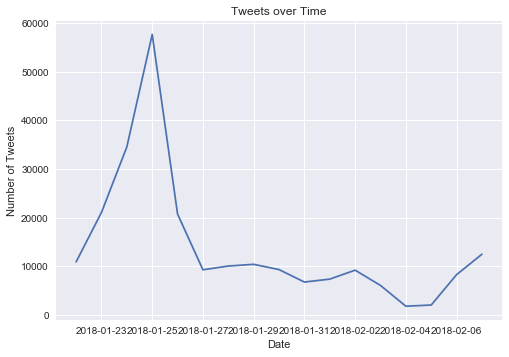

In [15]:
df.groupby(df['tweet_date'].dt.date).size().plot()
plt.title('Tweets over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

#### Process text for analysis

In [16]:
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
words = (df['text']
           .str.lower()
           .replace([r'\|', RE_stopwords, r"(&amp)|,|;|\"|\.|\?|’|!|'|:|-|\\|/|https"], [' ', ' ', ' '], regex=True)
           .str.cat(sep=' ')
           .split()
)

#### Most frequent words

In [17]:
rslt = pd.DataFrame(Counter(words).most_common(50),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt = rslt.iloc[5:] 
#top terms removed from graph because they are the search terms for the data collection

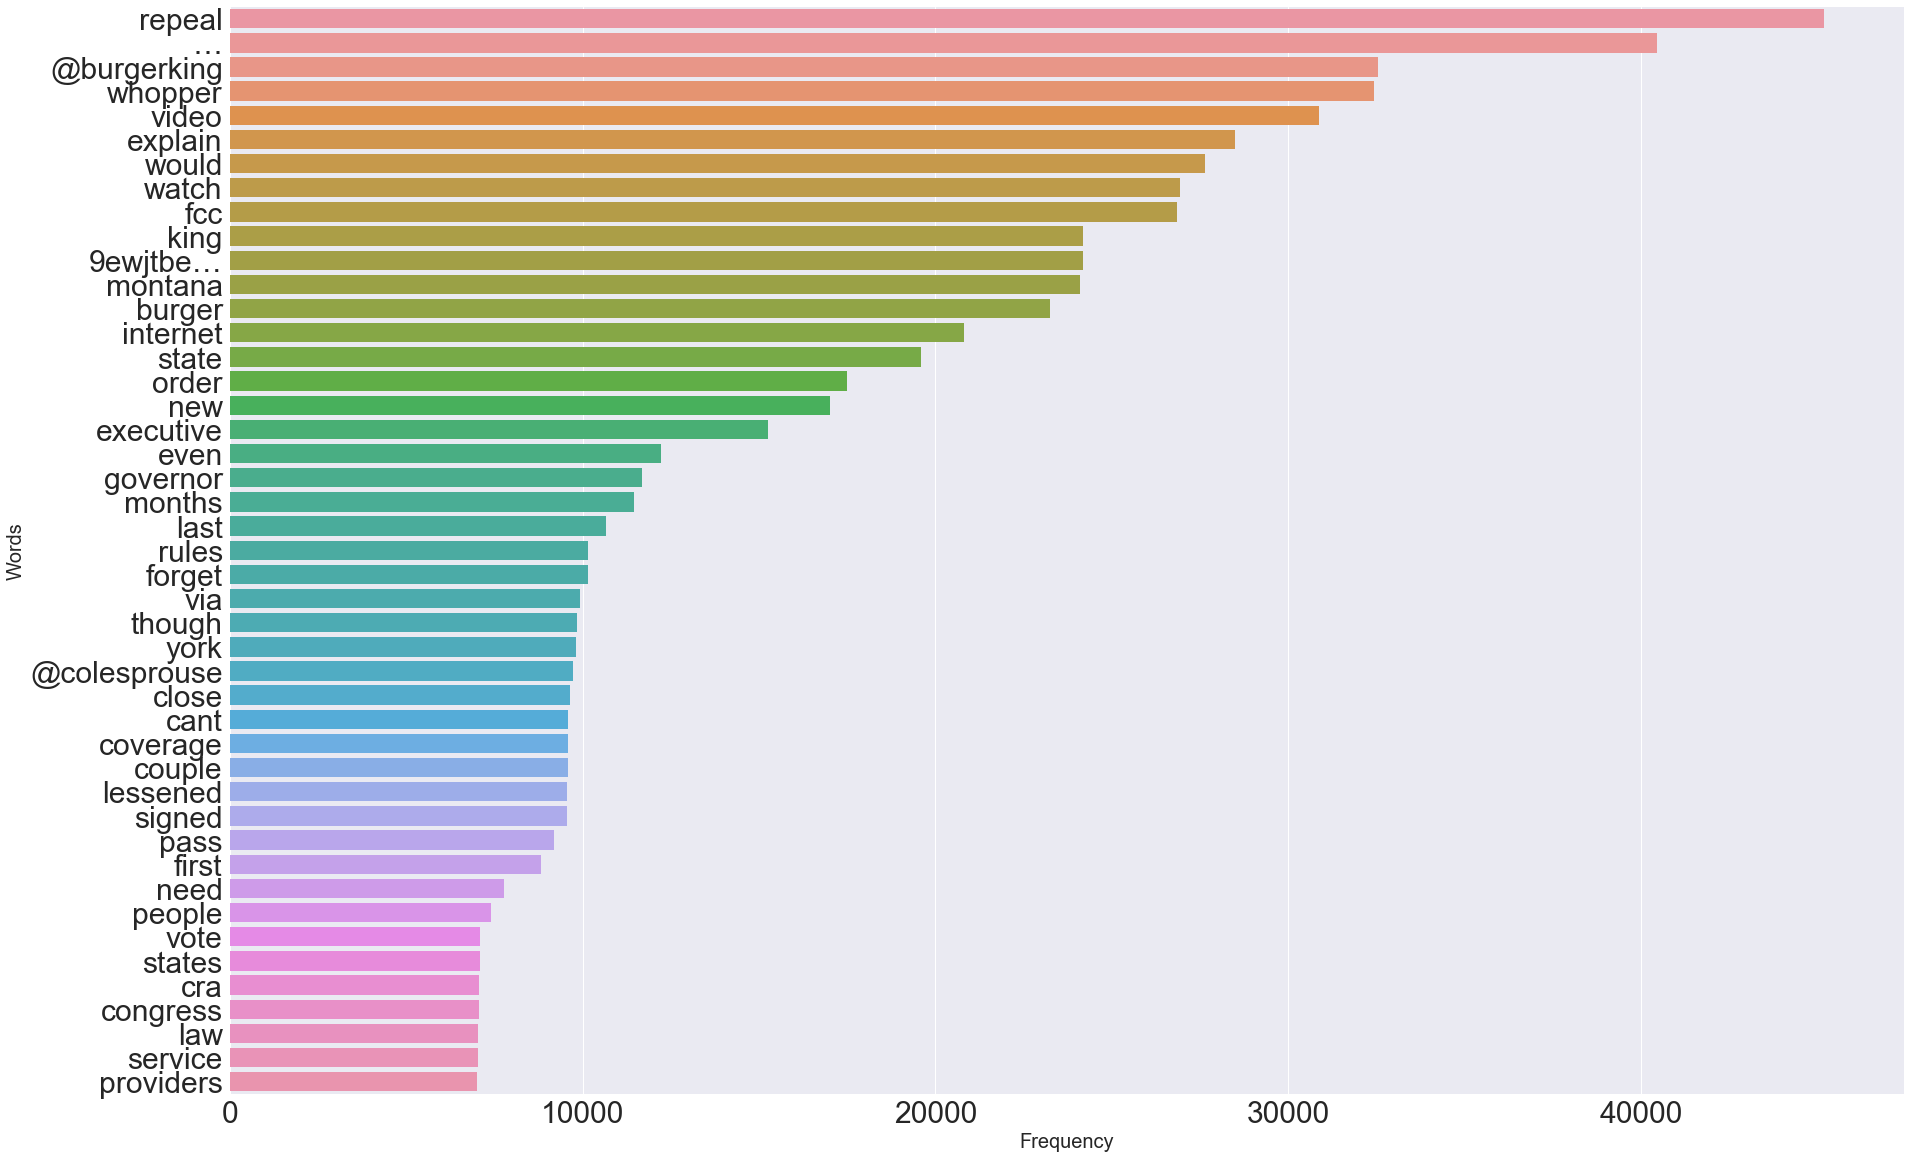

In [18]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [30.0, 20.0]
ax = sns.barplot(y=rslt.index, x='Frequency', data=rslt)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Words",fontsize=20)
ax.tick_params(labelsize=30)

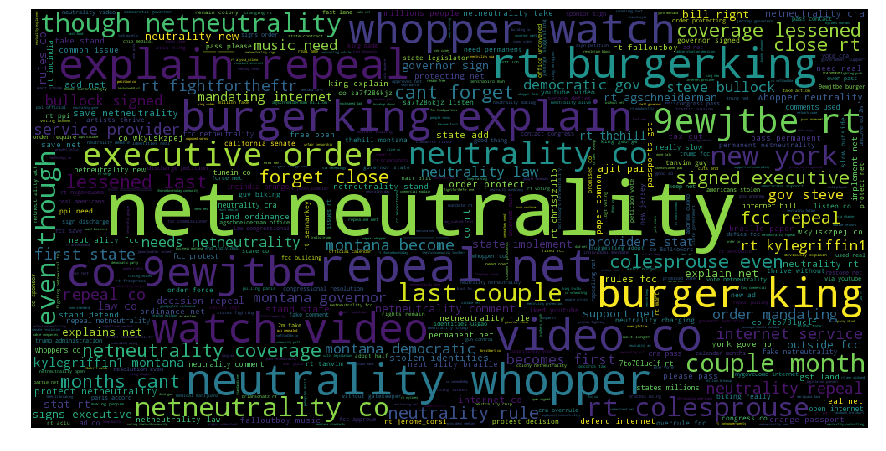

In [19]:
wordcloud = WordCloud(width = 1000, height = 500, max_words = 500).generate(' '.join(words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Word Co-Occurrences

In [20]:
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words, 2)
finder.apply_freq_filter(5)
for bigram in finder.nbest(bigram_measures.likelihood_ratio, 20):
    print(bigram)

('net', 'neutrality')
('burger', 'king')
('would', 'explain')
('watch', 'video')
('whopper', 'watch')
('@burgerking', 'would')
('explain', 'repeal')
('executive', 'order')
('co', '9ewjtbe…')
('repeal', 'net')
('video', 'co')
('coverage', 'lessened')
('neutrality', 'whopper')
('cant', 'forget')
('forget', 'close')
('lessened', 'last')
('last', 'couple')
('couple', 'months')
('months', 'cant')
('even', 'though')


#### Most Frequent Links

In [21]:
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

In [22]:
df['link'] = df['text'].apply(lambda tweet: extract_link(tweet))
tweets_with_link = df[df['link'] != '']

In [23]:
rslt3 = pd.DataFrame(Counter(tweets_with_link['link']).most_common(10),
                    columns=['Link', 'Frequency']).set_index('Link')

rslt3 = rslt3.iloc[1:]

In [24]:
print(rslt3)

                         Frequency
Link                              
https://t.co/wkyUSkzpeJ       2117
https://t.co/sA7f286KJZ       1602
https://t.co/k6CkqtnEB8       1044
https://t.co/…                 878
https://t.co/vmfTTWd3dM        815
https://t.co/vEtEqo1dTG        656
https://t.co/oabVsUk0sc        582
https://t.co/FOwGhk4B7a        552
https://t.co/zTIthImIFV        538


#### Tweets by Location

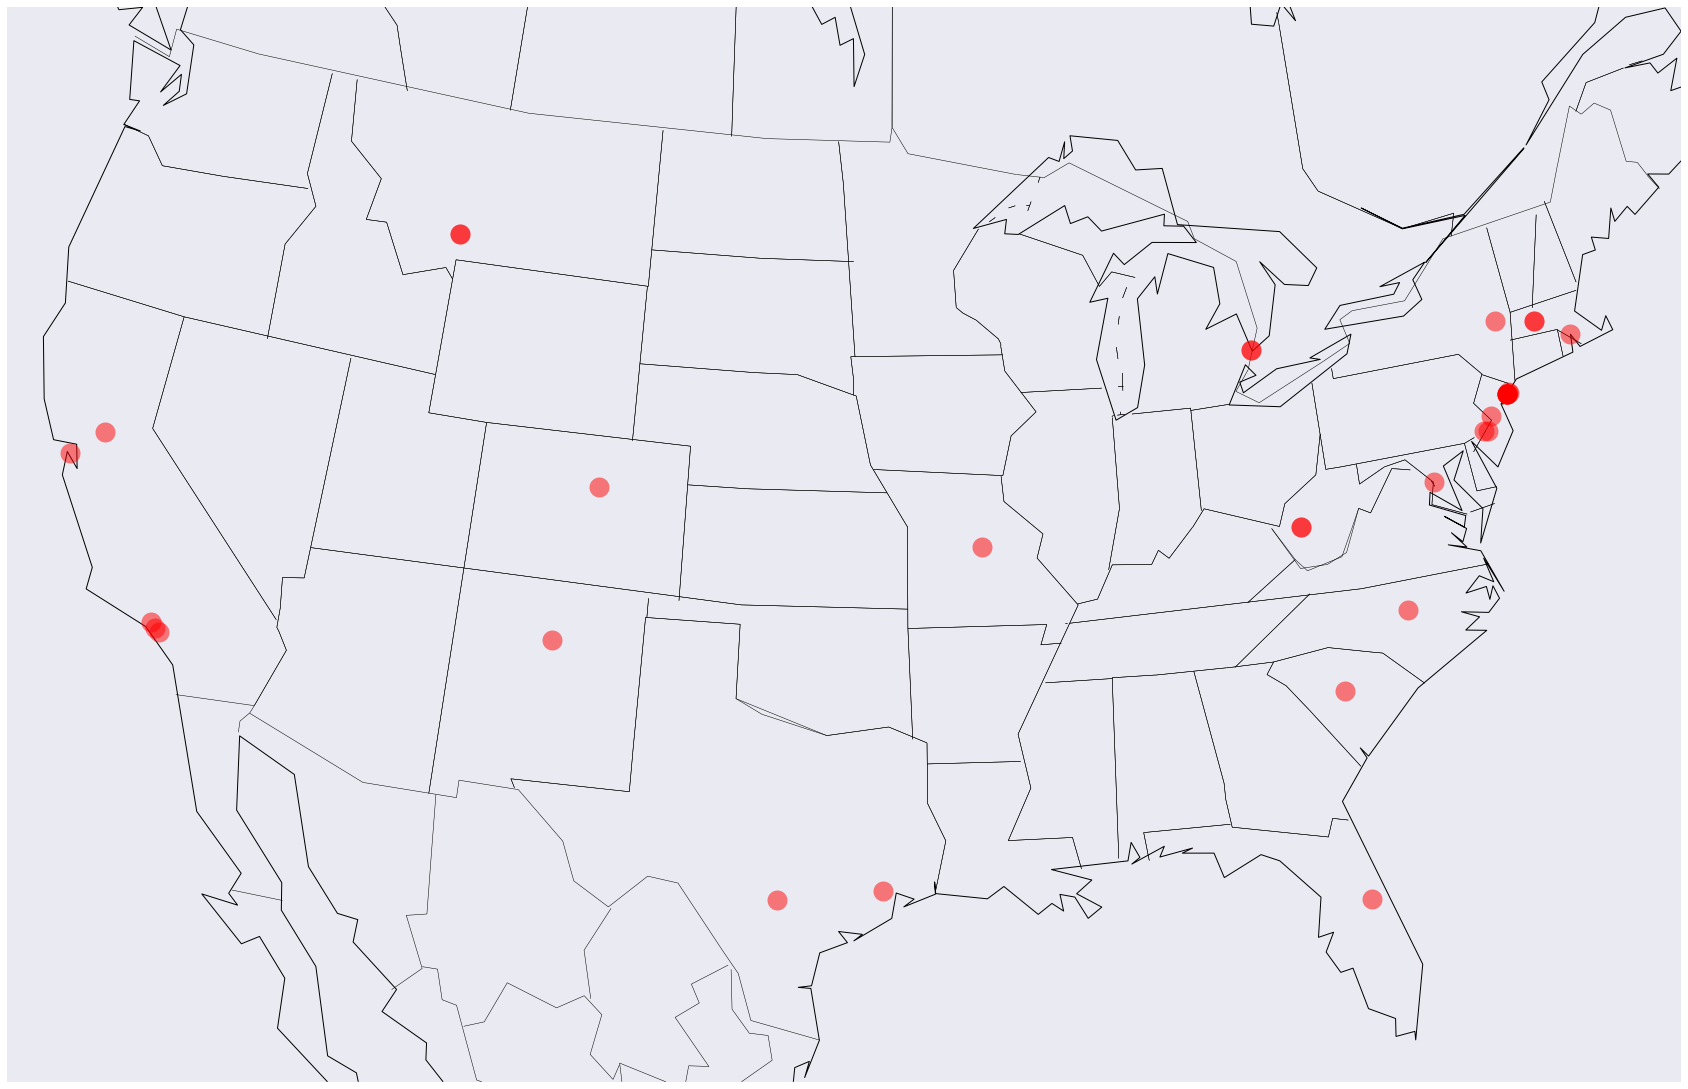

In [25]:
my_map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='c')
my_map.drawcoastlines()
my_map.drawstates()
my_map.drawcountries()
# add coordinates as red dots
longs = list(df.loc[(df.long != 'NaN')].long)
latts = list(df.loc[df.latt != 'NaN'].latt)
x, y = my_map(longs, latts)
my_map.plot(x, y, 'ro', markersize=20, alpha=0.5)
 
plt.show()

#### Top Users

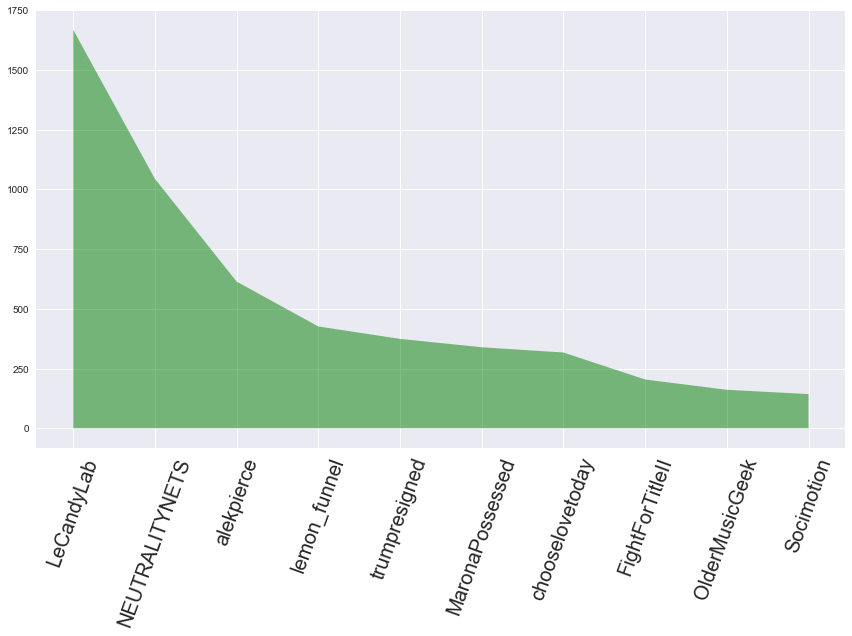

In [26]:
user_counts = df.screen_name.value_counts()[:10]
fig, ax = plt.subplots(1, figsize=(12, 9))
x = np.arange(len(user_counts.index))
ax.stackplot(x, user_counts.values, colors='g', alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(user_counts.index, fontsize=20, rotation=70)
ax.grid(color='w', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

## FCC Public Comments Data

#### Import Data

In [27]:
fcc = pd.read_csv('~/Desktop/proc_17_108_unique_comments_text_dupe_count.csv', index_col='docid')

#### Data Wrangling

In [28]:
fcc.head()

,text_data,dupe_count
docid,,
2,I work as an engineering manager at a small vi...,1.0
3,"Dear FCC,\r\n\r\nclowns. traitors. pawns pre...",1.0
5,I am AGAINST the push to remove net neutrality...,1.0
6,"Guys, I seriously don't understand your reason...",1.0
8,I do not support this proposal. Having a neut...,1.0


In [29]:
fcc.shape

(2955186, 2)

In [30]:
fcc.text_data.nunique()

2955181

In [31]:
# Remove duplicate comments
fcc = fcc.drop_duplicates(["text_data"])
fcc.shape

(2955182, 2)

In [32]:
fcc.dtypes

text_data      object
dupe_count    float64
dtype: object

#### Exploratory Data Analysis

In [33]:
fccwords = (fcc['text_data']
           .str.lower()
           .replace([r'\|', RE_stopwords, r"(&amp)|,|;|\"|\.|\?|’|!|'|:|-|\\|/|https"], [' ', ' ', ' '], regex=True)
           .str.cat(sep=' ')
           .split()
)

In [34]:
rslt4 = pd.DataFrame(Counter(fccwords).most_common(50),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt4 = rslt4.iloc[1:]

#### Most frequent words

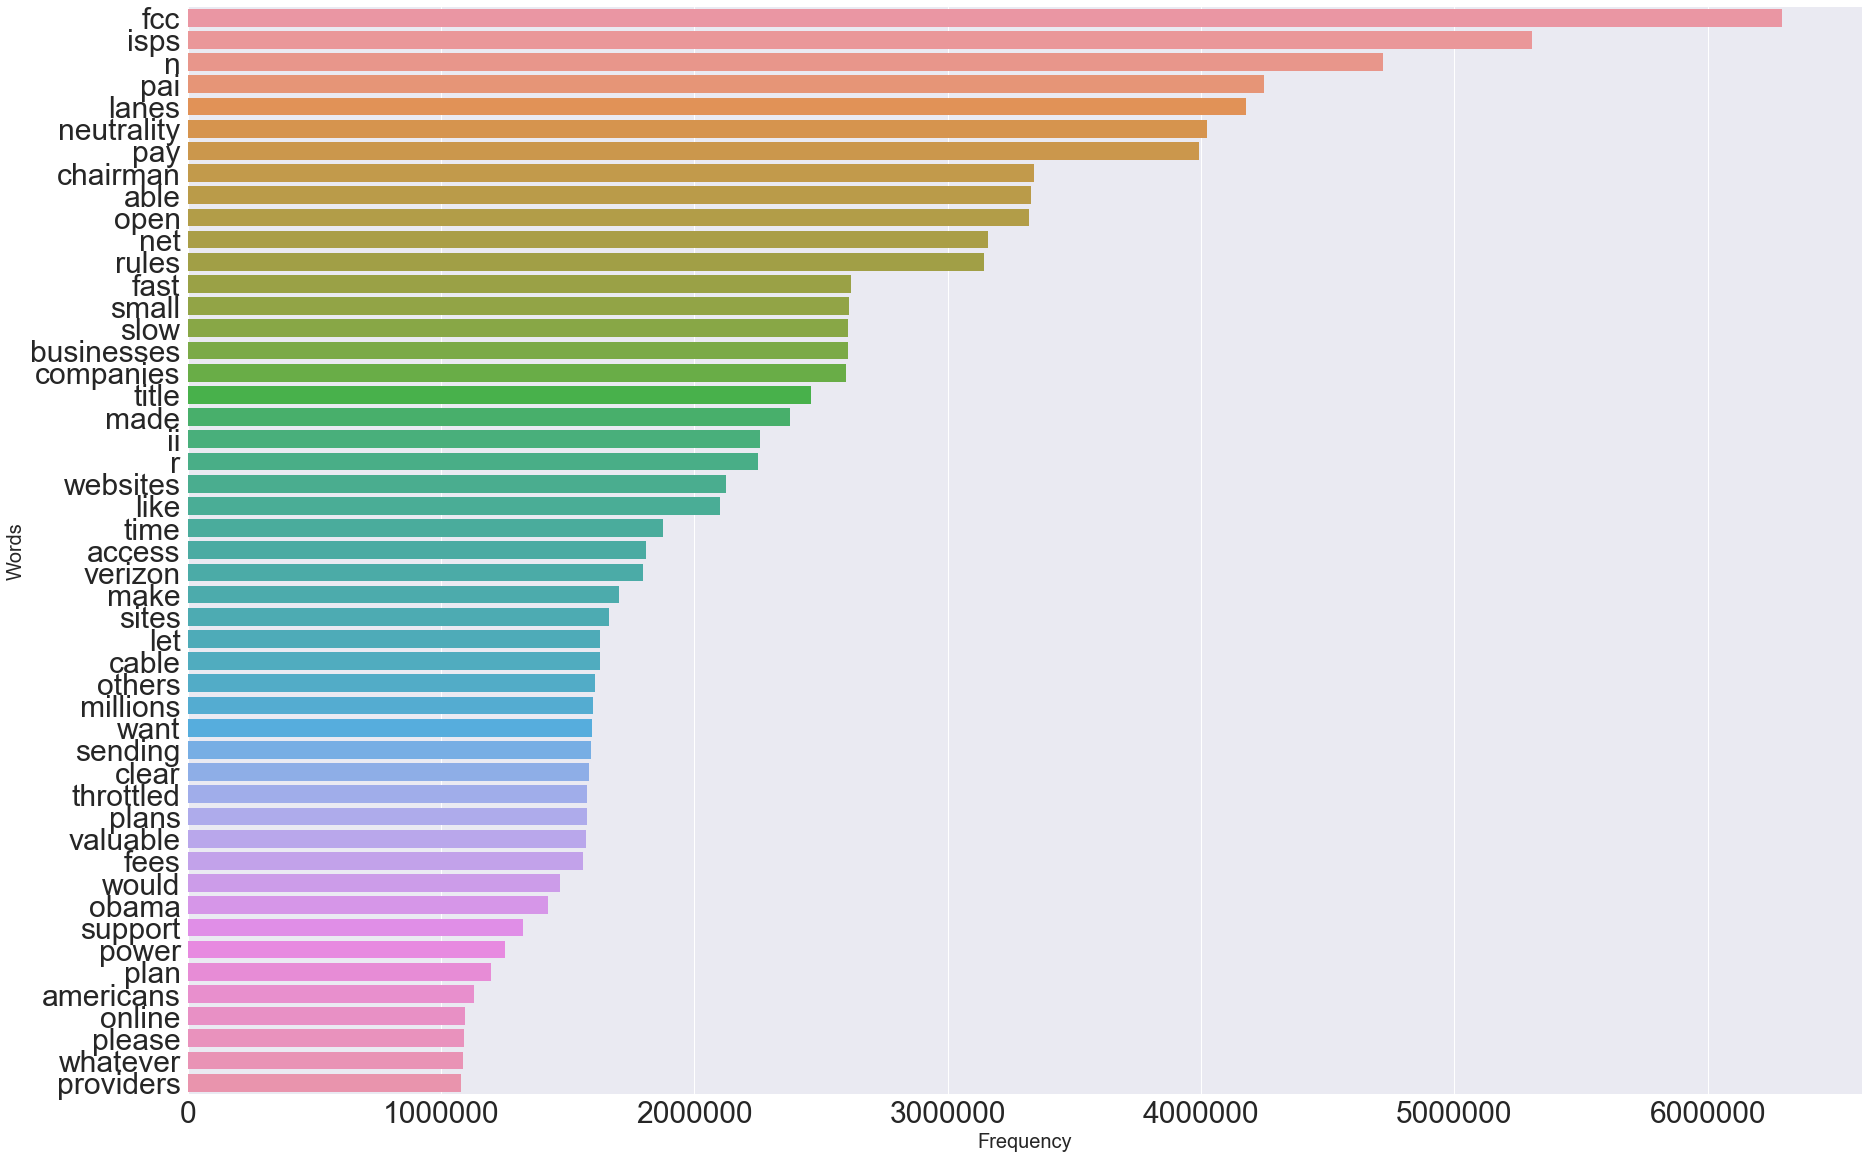

In [35]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [30.0, 20.0]
ax = sns.barplot(y=rslt4.index, x='Frequency', data=rslt4)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Words",fontsize=20)
ax.tick_params(labelsize=30)

In [37]:
finder2 = BigramCollocationFinder.from_words(fccwords, 2)
finder2.apply_freq_filter(5)
for bigram in finder2.nbest(bigram_measures.likelihood_ratio, 20):
    print(bigram)

('net', 'neutrality')
('chairman', 'pai')
('title', 'ii')
('fast', 'lanes')
('made', 'clear')
('small', 'businesses')
('league', 'legends')
('members', 'congress')
('famous', 'sky')
('admitted', 'introduce')
('rules)', 'extremely')
('serious', 'problem')
('abysmal', 'customer')
('marketplace', 'enabled')
('prices', 'abysmal')
('game', 'league')
('blogs', 'nonprofits')
('nonprofits', 'artists')
('created', '5')
('popular', 'game')
